In [20]:
import pandas as pd
import numpy as np

from statsmodels.api import add_constant
from numpy.linalg import lstsq
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

from skglm import GeneralizedLinearEstimator
from skglm.penalties import SCAD

from numba import njit

In [21]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [22]:
G = 3
GF = np.array((1, 1, 1))

In [23]:
from linearmodels.datasets import wage_panel

wage_panel_df = wage_panel.load()

wage_panel_df.set_index(["nr", "year"], inplace=True)
y = wage_panel_df["lwage"]
x = wage_panel_df.drop(columns=["occupation", "lwage", "black", "hisp", "educ"])
display(x)
display(y)

exper  hours  married  union  expersq
nr    year                                       
13    1980      1   2672        0      0        1
      1981      2   2320        0      1        4
      1982      3   2940        0      0        9
      1983      4   2960        0      0       16
      1984      5   3071        0      0       25
...           ...    ...      ...    ...      ...
12548 1983      8   2080        1      0       64
      1984      9   2080        1      1       81
      1985     10   2080        1      0      100
      1986     11   2080        1      1      121
      1987     12   3380        1      1      144

[4360 rows x 5 columns]

nr     year
13     1980    1.197540
       1981    1.853060
       1982    1.344462
       1983    1.433213
       1984    1.568125
                 ...   
12548  1983    1.591879
       1984    1.212543
       1985    1.765962
       1986    1.745894
       1987    1.466543
Name: lwage, Length: 4360, dtype: float64

In [24]:
N = x.index.get_level_values(0).nunique()
T = x.index.get_level_values(1).nunique()
K = x.shape[1]
N, T, K

(545, 8, 5)

In [25]:
x = x.values.reshape(N, T, K)
y = y.values.reshape(N, T, 1)
x, y

(array([[[   1, 2672,    0,    0,    1],
         [   2, 2320,    0,    1,    4],
         [   3, 2940,    0,    0,    9],
         ...,
         [   6, 2864,    0,    0,   36],
         [   7, 2994,    0,    0,   49],
         [   8, 2640,    0,    0,   64]],
 
        [[   4, 2484,    0,    0,   16],
         [   5, 2804,    0,    0,   25],
         [   6, 2530,    0,    0,   36],
         ...,
         [   9, 2164,    0,    0,   81],
         [  10, 2749,    0,    0,  100],
         [  11, 2476,    0,    0,  121]],
 
        [[   4, 2332,    1,    0,   16],
         [   5, 2116,    1,    0,   25],
         [   6, 2500,    1,    0,   36],
         ...,
         [   9, 2340,    1,    0,   81],
         [  10, 2340,    1,    0,  100],
         [  11, 2340,    1,    0,  121]],
 
        ...,
 
        [[   4, 2008,    1,    0,   16],
         [   5, 3190,    0,    0,   25],
         [   6, 2584,    0,    0,   36],
         ...,
         [   9, 2290,    1,    0,   81],
         [  10, 31

In [26]:
# x = x[:30]
# y = y[:30]
# N = 30
# x

In [27]:
x = np.concatenate((np.ones((N, T, 1)), x), axis=2)
x

array([[[1.000e+00, 1.000e+00, 2.672e+03, 0.000e+00, 0.000e+00,
         1.000e+00],
        [1.000e+00, 2.000e+00, 2.320e+03, 0.000e+00, 1.000e+00,
         4.000e+00],
        [1.000e+00, 3.000e+00, 2.940e+03, 0.000e+00, 0.000e+00,
         9.000e+00],
        ...,
        [1.000e+00, 6.000e+00, 2.864e+03, 0.000e+00, 0.000e+00,
         3.600e+01],
        [1.000e+00, 7.000e+00, 2.994e+03, 0.000e+00, 0.000e+00,
         4.900e+01],
        [1.000e+00, 8.000e+00, 2.640e+03, 0.000e+00, 0.000e+00,
         6.400e+01]],

       [[1.000e+00, 4.000e+00, 2.484e+03, 0.000e+00, 0.000e+00,
         1.600e+01],
        [1.000e+00, 5.000e+00, 2.804e+03, 0.000e+00, 0.000e+00,
         2.500e+01],
        [1.000e+00, 6.000e+00, 2.530e+03, 0.000e+00, 0.000e+00,
         3.600e+01],
        ...,
        [1.000e+00, 9.000e+00, 2.164e+03, 0.000e+00, 0.000e+00,
         8.100e+01],
        [1.000e+00, 1.000e+01, 2.749e+03, 0.000e+00, 0.000e+00,
         1.000e+02],
        [1.000e+00, 1.100e+01, 2.476e

In [28]:
def _get_factors_initial(y, GF, T):
    y_squeezed = np.squeeze(y).T
    pca = PCA(n_components=GF.sum())
    U = pca.fit_transform(y_squeezed)/pca.singular_values_
    F = np.sqrt(T) * U
    Lambda = F.T @ y_squeezed / T

    return F, Lambda


def _get_factors(y, x, beta, g, G, GF, T):
    y_squeezed = np.squeeze(y - x @ beta).T

    F = np.zeros((T, GF.sum()))
    Lambda = np.zeros((GF.sum(), y_squeezed.shape[1]))

    for i in range(G):
        y_squeezed_partial = np.atleast_2d(np.squeeze(y[g==i] - x[g==i] @ beta).T)

        pca = PCA(n_components=GF[i])
        U = pca.fit_transform(y_squeezed_partial) / pca.singular_values_

        F_partial = np.sqrt(T) * U
        F[:, GF[:i].sum():GF[:i+1].sum()] = F_partial

        Lambda_partial = F_partial.T @ y_squeezed / T
        Lambda[GF[:i].sum():GF[:i+1].sum(), :] = Lambda_partial

    return F, Lambda


def _get_clusters_initial(Lambda, G, GF):
    # FIXME this code is very bad, but it works
    while True:
        km = KMeans(n_clusters=G)
        g = km.fit_predict(Lambda.T)

        counts = np.bincount(g, minlength=G)
        if np.all(counts >= (GF + 1)):
            break

    return g

def _get_cluster_id(G, GF):
    cluster_id = np.zeros(GF.sum(), dtype=np.int8)
    for i in range(G):
        cluster_id[GF[:i].sum() : GF[: i + 1].sum()] = i
    return cluster_id

# FIXME this code should be modified s.t. cannot return groups less than size
# GF[i]
def _get_clusters(y, x, beta, Lambda, g, G, F, GF, N, T):
    y_star = y - x @ beta
    res = np.zeros((N, T, G))
    for i in range(G):
        # TODO check if this is correct
        # But I think so
        res[:,:,i] = y_star.reshape(N, -1) - (F[:, GF[:i].sum():GF[: i + 1].sum()] @ Lambda[GF[:i].sum():GF[: i + 1].sum(), :]).T
    res_per_grouping = (res ** 2).sum(axis=1)
    g = res_per_grouping.argmin(axis=1)

    # Count size of each group
    counts = np.bincount(g, minlength=G)

    # Ensure minimum group sizes (GF[i] + 1)
    min_sizes = GF + 1

    # Check if any group is below minimum size
    while np.any(counts < min_sizes):
        # Find the most deficient group
        target_group = np.argmin(counts - min_sizes)
        needed = min_sizes[target_group] - counts[target_group]

        if needed <= 0:
            continue  # This group already meets its minimum

        # Find elements not in this group
        non_target_indices = np.where(g != target_group)[0]

        # Sort by distance to target group
        distances = res_per_grouping[non_target_indices, target_group]
        closest_indices = non_target_indices[np.argsort(distances)]

        # Try to reassign closest elements
        reassigned = 0
        for idx in closest_indices:
            source_group = g[idx]

            # Only reassign if source group has enough elements to spare
            if counts[source_group] > min_sizes[source_group]:
                g[idx] = target_group
                counts[source_group] -= 1
                counts[target_group] += 1
                reassigned += 1

                if reassigned >= needed:
                    break

        # If we couldn't reassign any elements, we're stuck
        if reassigned == 0:
            raise Exception("Cannot satisfy minimum group size constraints.")

    objective_value = res_per_grouping[np.arange(N), g].sum()

    return g, objective_value

# NOTE this ignores the factor structure
def _estimate_beta_initial(y, x, K):
    # TODO check if this is correct
    beta = lstsq(x.reshape(-1, K), y.reshape(-1, 1), rcond=None)[0]
    return beta

def _estimate_beta(y, x, g, GF, F, Lambda, K, N, T, G, kappa, gamma):
    # TODO check if this is correct
    # FIXME no it is not, i is undefined and this formula does not work here
    res = np.zeros((N, T, G))
    for i in range(G):
        # TODO check if this is correct
        # But I think so
        res[:, :, i] = (
            y.reshape(N, -1)
            - (F[:, GF[:i].sum() : GF[: i + 1].sum()] @ Lambda[GF[:i].sum() : GF[: i + 1].sum(), :]).T
        )

    y_star = res[np.arange(N), :, g]
    # FIXME the np.arange could be cached or something
    if kappa == 0:
        beta = lstsq(x.reshape(-1, K), y_star.reshape(-1, 1), rcond=None)[0]
        return beta

    beta = np.atleast_2d(
        GeneralizedLinearEstimator(penalty=SCAD(alpha=kappa, gamma=gamma))
        .fit(x.reshape(-1, K), np.squeeze(y_star.reshape(-1, 1)))
        .coef_
    ).T
    return beta

    # TODO check if this is correct
    # But I think so
    # beta = GeneralizedLinearEstimator(penalty=SCAD()).fit(x.reshape(-1, K), y_star.reshape(-1, 1))
    # return beta


# def _get_initial_values(y, x, G, GF, N, T, K, kappa, gamma):
#     F, Lambda = _get_factors(y, GF, N)
#     g = _get_clusters(Lambda, G)


# FIXME implementation is almost correct, however there are some mistakes chat found
# I myself believe that the mistake is how F and Lambda are calculated and how the regroupings are
# done based on these estimations. Also there is a mistake in the beta estimation. So essentially
# the whole code is wrong.
def _grouped_interactive_effects_iteration(y, x, G, GF, N, T, K, kappa, gamma, tol, max_iterations):
    last_objective_value = np.inf
    F, Lambda = _get_factors_initial(y, GF, T)
    g = _get_clusters_initial(Lambda, G, GF)
    beta = _estimate_beta_initial(y, x, K)
    F, Lambda = _get_factors(y, x, beta, g, G, GF, T)

    obj_val_store = 5
    objective_values = np.zeros(obj_val_store)

    for i in range(max_iterations):
        g, objective_value = _get_clusters(y, x, beta, Lambda, g, G, F, GF, N, T)
        F, Lambda = _get_factors(y, x, beta, g, G, GF, T)
        beta = _estimate_beta(y, x, g, GF, F, Lambda, K, N, T, G, kappa, gamma)

        objective_values[i % obj_val_store] = objective_value
        if objective_values.max() - objective_values.min() < tol:
            break

        last_objective_value = objective_value

    return beta, g, F, Lambda, last_objective_value

def grouped_interactive_effects(y, x, G, GF=None, kappa=0.0, gamma=3.7, tol=1e-6, gife_iterations=100, max_iterations=1000):
    """Runs GIFE regression"""
    N, T, K = x.shape
    if GF is None:
        GF = np.array([1] * G)
    else:
        GF = np.array(GF)  # Ensures that is an np array

    best_objective_value = np.inf
    best_g = None
    best_beta = None
    best_F = None
    best_Lambda = None

    # FIXME Lamda returns all possible factors and not only the ones that are used

    for i in range(gife_iterations):
        beta, g, F, Lambda, objective_value = _grouped_interactive_effects_iteration(
            y, x, G, GF, N, T, K, kappa, gamma, tol, max_iterations
        )

        if objective_value < best_objective_value:
            best_objective_value = objective_value
            best_g = g
            best_beta = beta
            best_F = F
            best_Lambda = Lambda

    return best_beta, best_g, best_F, best_Lambda, best_objective_value

grouped_interactive_effects(y, x, G, GF, gife_iterations=100, kappa=0.00001)

(array([[ 1.77913967e+00],
        [-9.72149236e-03],
        [-9.00525904e-05],
        [ 1.94730981e-01],
        [ 1.85149256e-01],
        [-8.10189556e-04]]),
 array([1, 2, 2, 2, 0, 0, 0, 1, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 1, 2, 2,
        2, 0, 2, 2, 0, 1, 1, 2, 2, 2, 0, 2, 1, 1, 2, 0, 0, 2, 1, 0, 2, 0,
        2, 2, 2, 0, 2, 2, 2, 1, 0, 2, 1, 2, 0, 0, 2, 2, 1, 2, 0, 0, 2, 1,
        2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 1, 0, 2, 2, 0, 0, 2, 2,
        2, 2, 0, 2, 2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 0, 2,
        0, 1, 0, 0, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 0,
        1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 1,
        1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 0, 0, 2, 1, 2, 0, 2, 2, 0, 2,
        2, 0, 2, 0, 2, 0, 2, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
        2, 2, 0, 2, 1, 2, 0, 1, 2, 2, 0, 2, 2, 0, 1, 2, 0, 1, 2, 1, 1, 0,
        2, 1, 2, 2, 0, 0, 0, 2, 1, 2, 0, 2, 0, 2, 0, 0, 1, 2, 1, 1, 2, 2,
        2, 0, 2, 2, 0,

In [29]:
grouped_interactive_effects(y, x, G, GF, gife_iterations=1000)

(array([[ 1.81998666e+00],
        [-9.71977689e-03],
        [-9.00524113e-05],
        [ 1.94730933e-01],
        [ 1.85149034e-01],
        [-8.10286021e-04]]),
 array([2, 1, 1, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 1, 1,
        1, 0, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 2, 2, 1, 0, 0, 1, 2, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 2, 0, 1, 2, 1, 0, 0, 1, 1, 2, 1, 0, 0, 1, 2,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 2, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1,
        0, 2, 0, 0, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0,
        2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 2,
        2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1, 2, 0, 0, 1, 2, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
        1, 1, 0, 1, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 2, 1, 0, 2, 1, 2, 2, 0,
        1, 2, 1, 1, 0, 0, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 2, 1, 2, 2, 1, 1,
        1, 0, 1, 1, 0,

In [77]:
def _get_factors_initial(y, GF, T):
    y_squeezed = np.squeeze(y).T
    pca = PCA(n_components=GF.sum())
    U = pca.fit_transform(y_squeezed) / pca.singular_values_
    F = np.sqrt(T) * U
    Lambda = F.T @ y_squeezed / T

    return F, Lambda


def _get_factors_hetrogeneous(y, x, beta, g, G, GF, T, N):
    # NOTE this is not neeeded I believe
    F = np.zeros((T, GF.sum()))
    Lambda = np.zeros((GF.sum(), y.shape[0]))

    for i in range(G):
        y_squeezed_partial = np.atleast_2d(np.squeeze(y[g == i] - x[g == i] @ beta[:, i:i+1]).T)

        pca = PCA(n_components=GF[i])
        U = pca.fit_transform(y_squeezed_partial) / pca.singular_values_

        F_partial = np.sqrt(T) * U
        F[:, GF[:i].sum() : GF[: i + 1].sum()] = F_partial

        # NOTE that here the correct beta is used
        y_squeezed = np.squeeze(y - x @ beta[:, i:i+1]).T
        Lambda_partial = F_partial.T @ y_squeezed / T
        Lambda[GF[:i].sum() : GF[: i + 1].sum(), :] = Lambda_partial

    return F, Lambda


def _get_clusters_initial(Lambda, G, GF):
    # FIXME this code is very bad, but it works
    while True:
        km = KMeans(n_clusters=G)
        g = km.fit_predict(Lambda.T)

        counts = np.bincount(g, minlength=G)
        if np.all(counts >= (GF + 1)):
            break

    return g


def _get_cluster_id(G, GF):
    cluster_id = np.zeros(GF.sum(), dtype=np.int8)
    for i in range(G):
        cluster_id[GF[:i].sum() : GF[: i + 1].sum()] = i
    return cluster_id


# FIXME this code should be modified s.t. cannot return groups less than size
# GF[i]
def _get_clusters_hetrogeneous(y, x, beta, Lambda, g, G, F, GF, N, T):
    res = np.zeros((N, T, G))
    for i in range(G):
        # TODO check if this is correct
        # But I think so
        res[:, :, i] = (
            y.reshape(N, -1)
            - x @ beta[:, i]
            - (F[:, GF[:i].sum() : GF[: i + 1].sum()] @ Lambda[GF[:i].sum() : GF[: i + 1].sum(), :]).T
        )
    res_per_grouping = (res**2).sum(axis=1)
    g = res_per_grouping.argmin(axis=1)

    # Count size of each group
    counts = np.bincount(g, minlength=G)

    # Ensure minimum group sizes (GF[i] + 1)
    min_sizes = GF + 1

    # Check if any group is below minimum size
    while np.any(counts < min_sizes):
        # Find the most deficient group
        target_group = np.argmin(counts - min_sizes)
        needed = min_sizes[target_group] - counts[target_group]

        if needed <= 0:
            continue  # This group already meets its minimum

        # Find elements not in this group
        non_target_indices = np.where(g != target_group)[0]

        # Sort by distance to target group
        distances = res_per_grouping[non_target_indices, target_group]
        closest_indices = non_target_indices[np.argsort(distances)]

        # Try to reassign closest elements
        reassigned = 0
        for idx in closest_indices:
            source_group = g[idx]

            # Only reassign if source group has enough elements to spare
            if counts[source_group] > min_sizes[source_group]:
                g[idx] = target_group
                counts[source_group] -= 1
                counts[target_group] += 1
                reassigned += 1

                if reassigned >= needed:
                    break

        # If we couldn't reassign any elements, we're stuck
        if reassigned == 0:
            raise Exception("Cannot satisfy minimum group size constraints.")

    objective_value = res_per_grouping[np.arange(N), g].sum()

    return g, objective_value


# NOTE this ignores the factor structure
def _estimate_beta_initial_hetrogeneous(y, x, g, K, G):
    beta = np.zeros((K, G))
    for i in range(G):
        y_partial = y[g == i]
        x_partial = x[g == i]

        beta[:, i] = np.squeeze(lstsq(x_partial.reshape(-1, K), y_partial.reshape(-1, 1), rcond=None)[0])
    return beta


def _estimate_beta_hetrogeneous(y, x, g, GF, F, Lambda, K, N, T, G, kappa, gamma):
    # TODO check if this is correct
    # FIXME no it is not, i is undefined and this formula does not work here
    beta = np.zeros((K, G))
    res = np.zeros((N, T, G))
    for i in range(G):
        # TODO check if this is correct
        # But I think so
        res[:, :, i] = (
            y.reshape(N, -1) - (F[:, GF[:i].sum() : GF[: i + 1].sum()] @ Lambda[GF[:i].sum() : GF[: i + 1].sum(), :]).T
        )

    y_star = res[np.arange(N), :, g]
    # FIXME the np.arange could be cached or something
    if kappa == 0:
        for i in range(G):
            beta[:, i] = np.squeeze(lstsq(x[g==i].reshape(-1, K), y_star[g==i].reshape(-1, 1), rcond=None)[0])
        return beta

    for i in range(G):
        beta[:, i] = (GeneralizedLinearEstimator(penalty=SCAD(alpha=kappa, gamma=gamma))
            .fit(x[g==i].reshape(-1, K), np.squeeze(y_star[g==i].reshape(-1, 1)))
            .coef_)

    return beta

    # TODO check if this is correct
    # But I think so
    # beta = GeneralizedLinearEstimator(penalty=SCAD()).fit(x.reshape(-1, K), y_star.reshape(-1, 1))
    # return beta


# def _get_initial_values(y, x, G, GF, N, T, K, kappa, gamma):
#     F, Lambda = _get_factors(y, GF, N)
#     g = _get_clusters(Lambda, G)


# NOTE implementing some sort of VNS could be quite beneficial, as it would
# improve the performance of the algorithm quite a bit, though some modifications
# would be needed
def _grouped_interactive_effects_iteration_hetrogeneous(y, x, G, GF, N, T, K, kappa, gamma, tol, max_iterations):
    last_objective_value = np.inf
    F, Lambda = _get_factors_initial(y, GF, T)
    g = _get_clusters_initial(Lambda, G, GF)
    beta = _estimate_beta_initial_hetrogeneous(y, x, g, K, G)
    F, Lambda = _get_factors_hetrogeneous(y, x, beta, g, G, GF, T, K)

    obj_val_store = 5
    objective_values = np.zeros(obj_val_store)

    for i in range(max_iterations):
        g, objective_value = _get_clusters_hetrogeneous(y, x, beta, Lambda, g, G, F, GF, N, T)
        F, Lambda = _get_factors_hetrogeneous(y, x, beta, g, G, GF, T, K)
        beta = _estimate_beta_hetrogeneous(y, x, g, GF, F, Lambda, K, N, T, G, kappa, gamma)

        objective_values[i % obj_val_store] = objective_value
        if objective_values.max() - objective_values.min() < tol:
            break

        last_objective_value = objective_value

    return beta, g, F, Lambda, last_objective_value


def grouped_interactive_effects_hetrogeneous(y, x, G, GF = None, kappa=0.0, gamma=3.7, tol=1e-6, gife_iterations=100, max_iterations=1000):
    """Runs GIFE regression"""
    N, T, K = x.shape
    if GF is None:
        GF = np.array([1] * G)
    else:
        GF = np.array(GF)  # Ensures that is an np array

    best_objective_value = np.inf
    best_g = None
    best_beta = None
    best_F = None
    best_Lambda = None

    # FIXME Lamda returns all possible factors and not only the ones that are used

    for i in range(gife_iterations):
        beta, g, F, Lambda, objective_value = _grouped_interactive_effects_iteration_hetrogeneous(
            y, x, G, GF, N, T, K, kappa, gamma, tol, max_iterations
        )

        if objective_value < best_objective_value:
            best_objective_value = objective_value
            best_g = g
            best_beta = beta
            best_F = F
            best_Lambda = Lambda

    return best_beta, best_g, best_F, best_Lambda, best_objective_value


grouped_interactive_effects_hetrogeneous(y, x, G, GF, gife_iterations=100)

(array([[ 2.28126721e+00,  1.74270221e+00,  1.24503232e+00],
        [ 1.51137411e-01,  3.57671656e-02, -3.52699617e-03],
        [-2.46372239e-04, -1.65010739e-04, -9.18864797e-05],
        [ 4.86015972e-02,  8.64513587e-02,  1.49306387e-01],
        [ 2.50698058e-02,  7.71670374e-02,  9.95377891e-02],
        [-1.30034428e-02,  1.82661098e-05,  2.12912138e-03]]),
 array([2, 1, 0, 1, 0, 1, 0, 2, 1, 2, 2, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 2, 0, 1, 1, 1, 0, 1, 2, 2, 1, 1,
        0, 1, 2, 0, 2, 0, 1, 2, 0, 2, 0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 1,
        2, 1, 2, 0, 0, 1, 0, 1, 1, 2, 0, 1, 1, 0, 0, 2, 2, 1, 2, 1, 2, 2,
        1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 2, 1, 0, 2, 1, 2, 1, 2,
        1, 1, 1, 2, 1, 1, 0, 2, 0, 0, 1, 1, 0, 2, 2, 0, 2, 1, 1, 0, 0, 2,
        2, 2, 0, 0, 1, 1, 1, 2, 2, 1, 0, 2, 1, 1, 2, 0, 1, 2, 0, 2, 0, 2,
        2, 2, 1, 1, 0, 2, 1, 1, 1, 0, 0, 0, 2, 1, 2, 1, 1, 1, 0, 0, 1, 0,
        1, 2, 2, 1, 0, 1, 0, 1, 0, 2, 1,

In [31]:
grouped_interactive_effects_hetrogeneous(y, x, G, GF, gife_iterations=100)

(array([[ 1.22812353e+00,  2.28124935e+00,  1.72635102e+00],
        [ 1.90706778e-03,  1.51142333e-01,  4.02710833e-02],
        [-9.62130687e-05, -2.46372008e-04, -1.66325423e-04],
        [ 1.51350747e-01,  4.86018278e-02,  8.83958512e-02],
        [ 9.79905903e-02,  2.50690201e-02,  7.67235026e-02],
        [ 1.87113284e-03, -1.30037318e-02, -2.30373350e-04]]),
 array([0, 2, 1, 2, 1, 2, 1, 0, 2, 0, 0, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2,
        1, 1, 2, 2, 1, 2, 0, 1, 2, 1, 1, 0, 1, 2, 2, 2, 1, 2, 0, 0, 2, 2,
        1, 2, 0, 1, 0, 1, 2, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 1, 0, 1, 2, 2,
        0, 2, 0, 1, 1, 2, 1, 2, 2, 0, 1, 2, 2, 1, 1, 0, 0, 2, 0, 2, 0, 0,
        2, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 0, 2, 1, 0, 2, 0, 2, 0,
        2, 2, 2, 0, 2, 2, 1, 0, 1, 1, 2, 2, 1, 0, 0, 1, 0, 2, 2, 1, 1, 0,
        0, 0, 1, 1, 2, 2, 2, 0, 0, 2, 1, 0, 2, 2, 0, 1, 2, 0, 1, 0, 1, 0,
        0, 0, 2, 2, 1, 0, 2, 2, 2, 1, 1, 1, 0, 2, 0, 2, 2, 2, 1, 1, 2, 1,
        2, 0, 0, 2, 1, 2, 1, 2, 1, 0, 2,

In [156]:
import pickle
example = pickle.load(open("dgp2-example-7.pkl", "rb"))

In [157]:
x_example = example[0]
y_example = np.reshape(example[1], (300, 100, 1))
f_example = example[2]
g_example = example[3]
l_example = example[4]
beta_example = example[5]

In [158]:
res = grouped_interactive_effects_hetrogeneous(y_example, x_example, 3, [1, 1, 1], gife_iterations=100, kappa=0.0)
res

(array([[3.01314866, 2.01142662, 0.99119107],
        [2.96494196, 2.00279926, 1.00892808],
        [2.9849617 , 1.99733783, 0.97834566]]),
 array([0, 0, 0, 2, 1, 1, 1, 0, 0, 2, 2, 0, 2, 1, 0, 0, 1, 2, 0, 2, 0, 0,
        0, 0, 0, 1, 2, 1, 2, 0, 2, 1, 2, 0, 0, 2, 2, 2, 2, 1, 1, 1, 2, 0,
        2, 0, 1, 2, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 0, 1,
        0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 1, 2, 1, 1, 1, 0, 0,
        1, 0, 2, 0, 2, 2, 1, 0, 2, 2, 2, 1, 0, 2, 0, 1, 0, 1, 0, 0, 2, 2,
        2, 0, 0, 1, 2, 2, 2, 1, 2, 0, 1, 2, 1, 1, 2, 1, 2, 0, 2, 2, 0, 0,
        2, 1, 1, 0, 1, 2, 0, 1, 1, 2, 2, 2, 0, 0, 1, 0, 0, 1, 0, 2, 2, 2,
        0, 0, 1, 2, 2, 0, 2, 2, 2, 2, 2, 0, 1, 0, 2, 1, 0, 1, 0, 1, 2, 0,
        0, 1, 0, 0, 0, 2, 0, 1, 1, 1, 0, 2, 1, 0, 0, 2, 0, 1, 2, 2, 2, 2,
        1, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 2, 1, 2, 0, 0, 1, 2, 2, 0,
        0, 0, 2, 2, 0, 2, 1, 2, 1, 1, 2, 1, 1, 2, 0, 0, 1, 1, 0, 2, 1, 1,
        1, 2, 1, 0, 0, 0, 1, 0, 0, 0, 1, 2, 2,

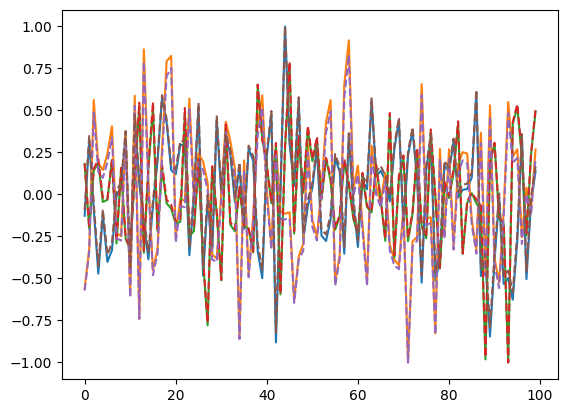

In [165]:
plt.plot((res[-3]/np.abs(res[-3]).max(axis=0)), label="Estimated factors")
plt.plot((f_example/np.abs(f_example).max(axis=0)), "--")
# plt.plot(l_example.T)
plt.show()

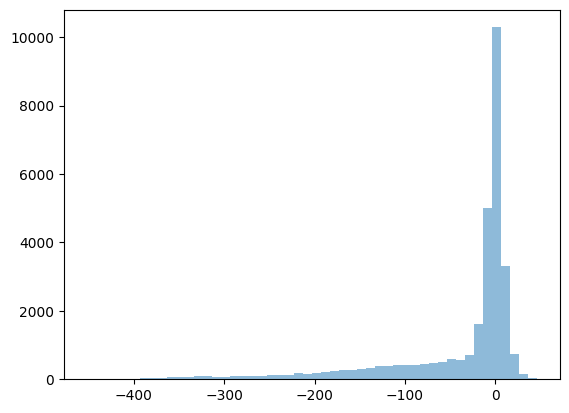

(107, 100)

In [152]:
y_est = np.zeros_like(y_example)

for i in range(107):
    y_est[i] = np.atleast_2d(np.squeeze((x_example[g_example==0] @ beta_example[0])[i]) + l_example[g_example == 0][i] * f_example[:, 0]).T

plt.hist(np.reshape(y_example - y_est, -1), bins=50, alpha=0.5, label="Group 0")
plt.show()

(x_example[g_example == 0] @ beta_example[0]).shape